<a href="https://colab.research.google.com/github/pinkesh-ai/DL201/blob/main/Brain_Tumor_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumour Diagnosis

### Imports and setup

In [ ]:

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 8.1 MB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 45.1 MB/s 
     |████████████████████████████████| 188 kB 71.9 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 51 kB 395 kB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


### Loading the dataset from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
%cd //content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d denizkavi1/brain-tumor

brain-tumor.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls

 Brain/              Drugs/         Kaggle/
 brain-tumor.zip    'FA20 '/        models/
'Colab Notebooks'/   filename.pkl   train_data_to2.pkl


###Data Preparation

In [ ]:
!unzip //content/gdrive/MyDrive/brain-tumor.zip -d /content/gdrive/MyDrive/Brain/dev/null

Archive:  //content/gdrive/MyDrive/brain-tumor.zip
checkdir:  cannot create extraction directory: /content/gdrive/MyDrive/Brain/dev/null
           No such file or directory


###Define a Path

In [ ]:
path = '/content/gdrive/MyDrive/Brain'

In [ ]:
Tumor_types = '1.Menin', '2.Glioma', '3.Pt'
Path = '/content/gdrive/MyDrive/Brain/'

fns = get_image_files(path)

In [ ]:
fns = get_image_files(path)
fns

(#3034) [Path('/content/gdrive/MyDrive/Brain/2.Glioma/1883.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1868.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/178.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/173.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1890.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1840.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1859.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/168.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1891.png'),Path('/content/gdrive/MyDrive/Brain/2.Glioma/1866.png')...]

In [ ]:
#failed = verify_images(fns)
#failed

In [ ]:
#failed.map('Path.unlink');

In [ ]:
Brains='/content/gdrive/MyDrive/Brain'

In [ ]:
#Item_tfms , Batch_tfms ? parent label, grant parent label? Resize 128, 244, 422 ?
Brains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
#Data Distribution
#valid_n = paths_dframe["train-valid"].sum()
#train_n = len(paths_dframe) - valid_n
#labels = ["train", "valid"]
#fig, ax = plt.subplots(1, 1)
#ax.bar(labels, [train_n, valid_n])
#ax.set_title("Distribution of Data in Train & Validation Sets", fontsize = 15)
#plt.show()

In [ ]:
blocks=(ImageBlock, CategoryBlock)

In [ ]:
dls = Brains.dataloaders(path)

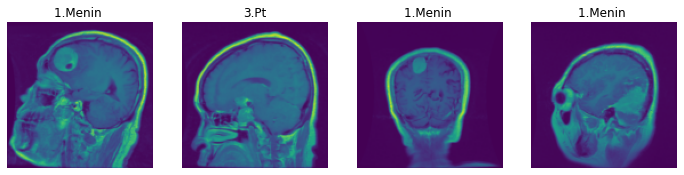

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

#### Experimented with Images

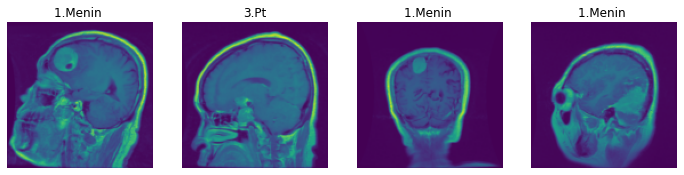

In [ ]:
#Squish
Brains = Brains.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = Brains.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

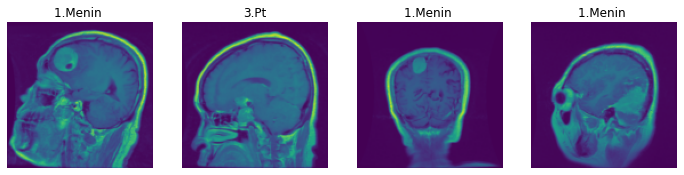

In [ ]:
#pad
Brains = Brains.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = Brains.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#RandomResizedCrop
#Brains = Brains.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
#dls = Brains.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


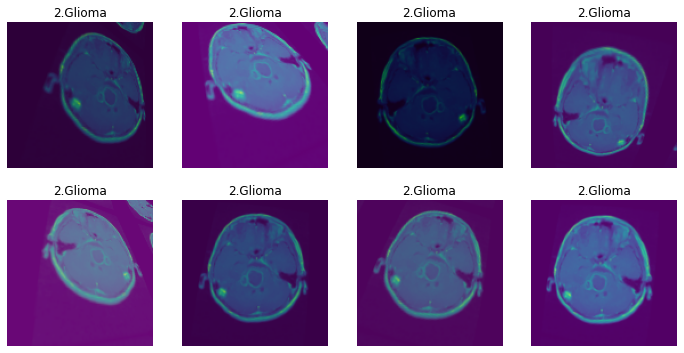

In [ ]:
#transforms
Brains = Brains.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = Brains.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

###Traning Model after modifying Images

In [ ]:
#check out the Learning Rate; Resnet34-Pretrained model on Imagenet
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 9.12e-03


In [ ]:
#Learning Rate=1e-02
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(2, base_lr=1e-02)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.130584,0.637200,0.202970,0.797030,07:52


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.583840,0.687680,0.158416,0.841584,00:37
1,0.391794,0.254369,0.095710,0.904290,00:37


In [ ]:
#Learning Rate=6.5e-02, Best So far
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(2, base_lr=6.5e-02)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.140690,1.416162,0.217822,0.782178,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.783941,0.753105,0.123762,0.876238,00:37
1,0.522858,0.280340,0.085809,0.914191,00:37


In [ ]:
#Learning Rate=8.5e-02
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(2, base_lr=8.5e-02)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.410287,0.893512,0.204620,0.795380,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.819539,4.301041,0.377888,0.622112,00:37
1,0.528390,0.227209,0.092409,0.907591,00:37


In [ ]:
#Learning Rate=5.5e-02  
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(2, base_lr=5.5e-02)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.203469,1.508530,0.293729,0.706271,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.795241,6.744295,0.283828,0.716172,00:37
1,0.522899,0.300663,0.089109,0.910891,00:37


In [ ]:
#Learning Rate=6.5e-02, 10 Epoch
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(10, base_lr=6.5e-02)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.240028,1.809712,0.224422,0.775578,00:36


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.785233,0.875204,0.222772,0.777228,00:37
1,0.520356,1.495229,0.308581,0.691419,00:37
2,0.418411,0.693381,0.118812,0.881188,00:37
3,0.416410,0.649740,0.268977,0.731023,00:37
4,0.360816,0.186597,0.072607,0.927393,00:37
5,0.302936,0.238313,0.089109,0.910891,00:37
6,0.255500,0.136173,0.044554,0.955446,00:37
7,0.208032,0.130893,0.041254,0.958746,00:37
8,0.164341,0.121995,0.042904,0.957096,00:37
9,0.129495,0.117667,0.042904,0.957096,00:37


In [ ]:
#unfreeze
learn.unfreeze()

SuggestedLRs(minimum=3.0199516913853586e-06, steep=6.309573450380412e-07)

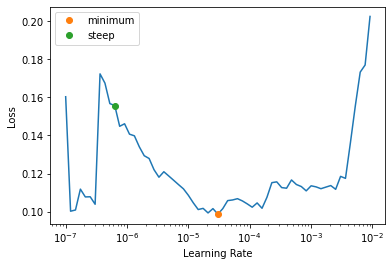

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
# Am I doing something wrong here?How come learning rate is same ?
print(f"Minimum/10: {lr_min:.1e}, steepest point: {lr_steep:.1e}")

Minimum/10: 1.0e-02, steepest point: 9.1e-03


In [ ]:
#learn = cnn_learner(dls,metrics=error_rate)
#learn.fit_one_cycle(10, lr_max=9.12e-03)
learn.fit_one_cycle(n_epoch, div_final=100000.0, pct_start=0.25, wd=None, moms=None, cbs=None, reset_opt=False)

SyntaxError: ignored

In [ ]:
learn.fit_one_cycle(3, lr_max=6.5e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.793601,0.664027,0.298680,00:37
1,0.765372,0.646365,0.272277,00:37
2,0.755953,0.648334,0.273927,00:38


In [ ]:
learn.fit_one_cycle(3, lr_max=1.5e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.745702,1.990731,0.280528,00:37
1,0.728258,0.638206,0.265677,00:36
2,0.736008,1.454470,0.277228,00:37


In [ ]:
### Training the Model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-4,9.12e-03))

epoch,train_loss,valid_loss,error_rate,time
0,1.296466,0.545769,0.198020,00:35
1,0.938935,0.449975,0.155116,00:37
2,0.762841,0.441317,0.150165,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.579876,0.551094,0.174917,00:36
1,0.506470,0.422126,0.107261,00:36
2,0.415461,0.297188,0.099010,00:37
3,0.319955,0.170243,0.056106,00:36
4,0.282443,0.215290,0.094059,00:37
5,0.240721,1.185826,0.072607,00:35
6,0.210712,0.404034,0.089109,00:37
7,0.193669,0.110786,0.037954,00:37
8,0.155428,0.155789,0.049505,00:36
9,0.127060,0.122246,0.041254,00:37


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(7, lr_max=slice(1e-3,1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,1.245176,0.490449,0.186469,00:36
1,0.914919,0.390600,0.155116,00:35
2,0.729455,0.402318,0.153465,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.642461,0.809431,0.214521,00:35
1,0.496410,0.373808,0.095710,00:37
2,0.405814,0.332810,0.117162,00:36
3,0.310889,0.190916,0.072607,00:37
4,0.257508,0.135099,0.047855,00:36
5,0.203025,0.135355,0.054455,00:37
6,0.157182,0.124782,0.051155,00:36


In [ ]:
learn.export("filename.pkl")

In [ ]:
#studying model #resnet50 using tensor core and mixedprecision
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.123207,0.769698,0.268977,00:36
1,0.925141,0.624848,0.161716,00:36
2,0.799713,0.562463,0.174917,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.552670,0.387230,0.132013,00:36
1,0.454768,0.297393,0.094059,00:37
2,0.378559,0.223726,0.082508,00:37
3,0.300561,0.215180,0.070957,00:36
4,0.231944,0.138575,0.051155,00:37
5,0.198466,0.144534,0.052805,00:36


In [ ]:
# resnet101
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet101, metrics=error_rate).to_fp16()
learn.fine_tune(8, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.175171,0.836594,0.235974,00:37
1,0.923279,0.584526,0.173267,00:38
2,0.771290,0.513301,0.178218,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.504251,0.385023,0.132013,00:38
1,0.407595,0.338063,0.112211,00:37
2,0.364202,0.430737,0.115512,00:39
3,0.300877,0.196885,0.069307,00:37
4,0.238616,0.154811,0.064356,00:39
5,0.185887,0.219223,0.059406,00:37
6,0.155108,0.161338,0.049505,00:39
7,0.134007,0.151621,0.047855,00:38


In [ ]:
#resnet152
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet152, metrics=error_rate).to_fp16()
learn.fine_tune(8, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.187082,0.701251,0.209571,00:38
1,0.918376,0.766882,0.219472,00:39
2,0.782603,0.466495,0.166667,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.525075,0.316950,0.113861,00:41
1,0.418009,0.253389,0.090759,00:41
2,0.360910,0.190627,0.061056,00:41
3,0.284252,0.195493,0.061056,00:40
4,0.225635,0.163117,0.057756,00:40
5,0.167214,0.151401,0.046205,00:41
6,0.129671,0.117837,0.047855,00:39
7,0.107575,0.115934,0.042904,00:41


In [ ]:
#resnet152
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fine_tune(5, freeze_epochs=1)

epoch,train_loss,valid_loss,error_rate,time
0,1.198005,0.662651,0.227723,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.726078,0.478859,0.173267,00:35
1,0.602046,0.321938,0.108911,00:35
2,0.508191,0.298062,0.110561,00:36
3,0.419828,0.236278,0.080858,00:35
4,0.352681,0.233176,0.080858,00:35


In [ ]:
#xresnet18
from fastai.callback.fp16 import *
learn = cnn_learner(dls, xresnet18, metrics=accuracy).to_fp16()
learn.fine_tune(5, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.224402,0.659612,0.747525,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.842992,0.597373,0.777228,00:34
1,0.792450,0.744550,0.740924,00:34
2,0.737651,0.601612,0.775578,00:34
3,0.682642,0.647559,0.757426,00:34
4,0.644671,0.596578,0.768977,00:34


In [ ]:
#Item_tfms , Batch_tfms ?Resize #128 244
Brains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(244))

In [ ]:
#resnet34 after resize244
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()
learn.fine_tune(8, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.524617,0.621520,0.724422,00:35
1,1.072173,0.460674,0.813531,00:35
2,0.904985,0.502083,0.811881,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.579653,0.391583,0.861386,00:35
1,0.509338,0.352791,0.871287,00:35
2,0.420583,0.212834,0.914191,00:35
3,0.357967,0.223718,0.910891,00:35
4,0.295527,0.298939,0.910891,00:35
5,0.259186,0.188481,0.937294,00:35
6,0.212346,0.149921,0.935644,00:35
7,0.185792,0.150902,0.937294,00:35


In [ ]:
#Learning Rate=6.5e-02, 10 Epoch
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(10, base_lr=6.5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.204460,1.441423,0.772277,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.732963,0.855916,0.821782,00:37
1,0.528134,0.351692,0.897690,00:36
2,0.424364,0.369078,0.869637,00:37
3,0.357245,0.214507,0.924092,00:36
4,0.319880,0.169226,0.929043,00:37
5,0.253786,0.149510,0.950495,00:37
6,0.198518,0.171535,0.933993,00:37
7,0.157271,0.121230,0.965347,00:37
8,0.122974,0.121034,0.963696,00:36
9,0.106633,0.109626,0.962046,00:37


In [ ]:
#resnet34 after resize422, #Item_tfms , Batch_tfms ?Resize; #128, #244 , 422
Brains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(422))

In [ ]:
#resnet34 after resize422
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet34, metrics=accuracy).to_fp16()
learn.fine_tune(8, freeze_epochs=3)


epoch,train_loss,valid_loss,accuracy,time
0,1.458292,0.656049,0.732673,00:35
1,1.105743,0.579195,0.792079,00:35
2,0.918717,0.525648,0.800330,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.630772,0.367826,0.861386,00:35
1,0.546010,0.294153,0.894389,00:36
2,0.444333,0.314749,0.899340,00:35
3,0.361619,0.292419,0.912541,00:36
4,0.302939,0.218264,0.917492,00:36
5,0.255978,0.218210,0.933993,00:36
6,0.226250,0.182014,0.937294,00:36
7,0.188095,0.183195,0.933993,00:36


In [ ]:
#Learning Rate=6.5e-02, 10 Epoch
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(10, base_lr=6.5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.305799,1.632174,0.777228,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.810788,0.615280,0.879538,00:37
1,0.558504,1.633310,0.712871,00:36
2,0.485889,0.190169,0.927393,00:37
3,0.391797,7.769729,0.405941,00:36
4,0.335110,0.207699,0.933993,00:36
5,0.283609,0.192030,0.930693,00:36
6,0.245122,0.167987,0.929043,00:36
7,0.194487,0.120006,0.953795,00:36
8,0.145260,0.108763,0.968647,00:36
9,0.132942,0.123131,0.960396,00:36


In [ ]:
#resize512
Brains = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(512))

In [ ]:
#resnet34 after resize512, base lr=1e-02
#Learning Rate=6.5e-02, 10 Epoch
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(10, base_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.099404,0.587044,0.811881,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.536308,0.294888,0.872937,00:37
1,0.420402,0.360761,0.881188,00:37
2,0.355553,0.364760,0.874587,00:36
3,0.300401,0.376926,0.877888,00:36
4,0.250666,0.212809,0.925743,00:36
5,0.213571,0.196546,0.937294,00:37
6,0.177747,0.175472,0.938944,00:37
7,0.147266,0.228053,0.914191,00:36
8,0.123688,0.154763,0.942244,00:36
9,0.099918,0.142000,0.950495,00:36


In [ ]:
#resnet34 after resize512, base lr=1e-02
#Learning Rate=6.5e-02, 10 Epoch
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(15, base_lr=5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.124730,1.059054,0.798680,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.710021,0.515519,0.844885,00:37
1,0.504188,0.259760,0.902640,00:36
2,0.428770,0.288585,0.897690,00:36
3,0.337493,0.264044,0.925743,00:36
4,0.321839,0.628433,0.844885,00:36
5,0.265946,0.284726,0.920792,00:36
6,0.246068,0.361733,0.891089,00:36
7,0.213296,12.882558,0.674918,00:37
8,0.236861,1.656202,0.948845,00:36
9,0.235062,0.327967,0.924092,00:36


In [ ]:
#resnet34 after resize512,
#Learning Rate=6.5e-02, 5Epoch
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(5,6.5e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.199953,0.868024,0.831683,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.930300,0.437597,0.843234,00:36
1,0.559517,0.538126,0.818482,00:36
2,0.389143,0.171948,0.925743,00:36
3,0.292810,0.131891,0.953795,00:36
4,0.224563,0.140896,0.948845,00:36


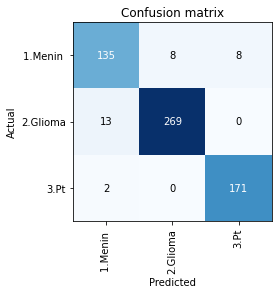

In [ ]:
#Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
learn.export("Resnet_bt.pkl")

###squeezenet

In [ ]:
from torchvision.models import SqueezeNet,squeezenet1_0,squeezenet1_1

In [ ]:
#squeezenet1_0, 

In [ ]:
#squeezenet1_1

In [ ]:
###squeezenet

###Interpretation

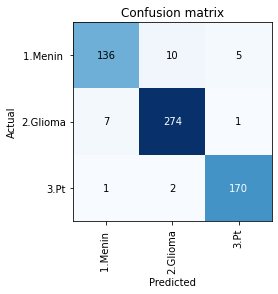

In [ ]:
#Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

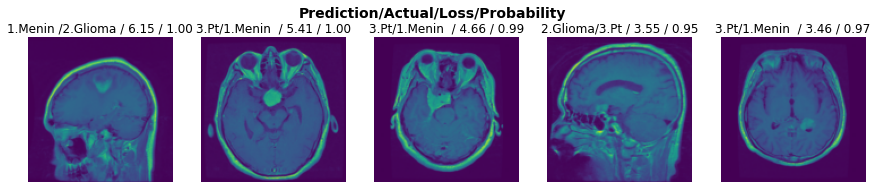

In [ ]:
#toploss
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Lets Apply Mnst applications

In [ ]:
from math import log10

def run_n_epochs(model, lr, params, n_epochs):
    trigger = 10**(int(log10(n_epochs))-1)
    cols = 10
    starting_i = metric_results['epochs'][-1] + 1
    for i in range(starting_i, starting_i + n_epochs):
        train_epoch(model, lr, params)
        if i%trigger == 0:
            v = validate_epoch(classifier)

            metric_results['epochs'].append(i)
            metric_results['values'].append(v)
            
            end_str = '\n' if i//trigger%cols == 0 else ' ' 
            print(f"{i:3d}:{v:1.4f}", end=end_str)
    print(f"\nLast:{v:1.4f}")
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    ax.scatter(metric_results['epochs'], metric_results['values'])
    return metric_results